In [73]:
import numpy as np
import pandas as pd
import torch

import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

from sklearn.manifold import TSNE
from sklearn.model_selection import GridSearchCV
import plotly.express as px

# VAE model design

In [2]:
class CustomDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

In [3]:
class VAE(nn.Module):
    def __init__(self, latent_dim):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(230,128),
            nn.ReLU(True),
            nn.Linear(128,64),
            nn.ReLU(True),
            nn.Linear(64,latent_dim*2)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim,64),
            nn.ReLU(True),
            nn.Linear(64,128),
            nn.ReLU(True),
            nn.Linear(128,230)
        )
    
    def encode(self, x):
        mean_logvar = self.encoder(x)
        mean, log_var = torch.chunk(mean_logvar, 2, dim=1)
        return mean, log_var
    
    def reparaterize(self, mean, log_var):
        std = torch.exp(0.5*log_var)
        eps = torch.randn_like(std)
        return mean + eps*std
    
    def decode(self, z):
        return self.decoder(z)
    
    def forward(self, x):
        mean, log_var = self.encode(x)
        z = self.reparaterize(mean, log_var)
        return self.decode(z), mean, log_var

In [4]:
# VAE loss function
def vae_loss(x, x_recon, mean, log_var):
    recon_loss = nn.MSELoss()(x_recon, x)
    kl_loss = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())
    return recon_loss + kl_loss

## Data import and feature selection

### Single

In [5]:
single_emo = pd.read_csv('/Users/jiachenyao/Desktop/Thesis/Preprocessed_data/single_emo_facial_no_time_6.csv')
#single_emo = pd.read_csv('/Users/jiachenyao/Desktop/Thesis/Preprocessed_data/single_emo_facial_no_time_1d.csv')

In [6]:
# select 100 features (mouth)
#single_emo =  single_emo.iloc[:, np.concatenate([range(0,1),range(343,363), range(411,431),range(479,499),range(547,567),range(615,635)])]

# eye_lmk: 0-7, 28-35 眼珠子外圈
# eye brow: 17-26
# mouth: 48-67
# 230 features
#single_emo = single_emo.iloc[:, np.concatenate([range(0,1),range(9,17), range(37,45),range(65,73),range(93,101),range(121,129),range(149,157), 
                                            #range(177,185),range(205,213),range(233,241),range(263,271), 
                                            #range(312,322),range(380,390),range(448,458),range(516,526),range(584,594), # eye brow: 17-26
                                            #range(343,363), range(411,431),range(479,499),range(547,567),range(615,635)])] ## mouth: 48-67

# 31 features
#single_emo = single_emo.iloc[:, np.concatenate([range(0,1),range(289,295), range(675,692)])]

# only AU
single_emo = single_emo.iloc[:, np.concatenate([range(0,1),range(675,692)])]

# only gaze
#single_emo = single_emo.iloc[:, np.concatenate([range(0,9)])]

### Mix

In [82]:
mix_emo = pd.read_csv('/Users/jiachenyao/Desktop/Thesis/Preprocessed_data/Mixed_emotions_noratio_notime_6.csv')

In [83]:
# select 100 features (mouth)
#mix_emo = mix_emo.iloc[:, np.concatenate([range(0,1),range(343,363), range(411,431),range(479,499),range(547,567),range(615,635)])]

# eye_lmk: 0-7, 28-35 眼珠子外圈
# eye brow: 17-26
# mouth: 48-67
# 230 features
#mix_emo = mix_emo.iloc[:, np.concatenate([range(0,1),range(9,17), range(37,45),range(65,73),range(93,101),range(121,129),range(149,157), 
                                            #range(177,185),range(205,213),range(233,241),range(263,271), 
                                            #range(312,322),range(380,390),range(448,458),range(516,526),range(584,594), # eye brow: 17-26
                                            #range(343,363), range(411,431),range(479,499),range(547,567),range(615,635)])] ## mouth: 48-67

# 31 features
#mix_emo = mix_emo.iloc[:, np.concatenate([range(0,1),range(289,295), range(675,692)])]

# only AU
mix_emo = mix_emo.iloc[:, np.concatenate([range(0,1),range(675,692)])]

# only gaze
#single_emo = single_emo.iloc[:, np.concatenate([range(0,9)])]

# VAE

## Single

In [7]:
# Label and data extraction
single_string_label = single_emo.iloc[:, 0].values
single_data = single_emo.iloc[:, 1:].values

# Label encoding
le = LabelEncoder()
single_labels = le.fit_transform(single_string_label)
single_label_mapping = dict(zip(single_labels, single_string_label))

In [58]:
# Train test split
single_X_train, single_X_val, single_y_train, single_y_val = train_test_split(single_data, single_labels, test_size=0.2, random_state=42)

In [59]:
# single emotion dataset
single_train_dataset = CustomDataset(torch.tensor(single_X_train, dtype=torch.float32), torch.tensor(single_y_train, dtype=torch.long))
single_val_dataset = CustomDataset(torch.tensor(single_X_val, dtype=torch.float32), torch.tensor(single_y_val, dtype=torch.long))
single_complete_dataset = CustomDataset(torch.tensor(single_data, dtype=torch.float32), torch.tensor(single_labels, dtype=torch.long))

In [60]:
# single emotion dataloader
single_train_loader = DataLoader(single_train_dataset, batch_size=32, shuffle=True)
single_val_loader = DataLoader(single_val_dataset, batch_size=32, shuffle=False)
single_complete_loader = DataLoader(single_complete_dataset, batch_size=32, shuffle=False)

In [61]:
# Train VAE
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
latent_dim = 20
mix_vae = VAE(latent_dim).to(device)
single_vae = VAE(latent_dim).to(device)
mix_optimizer = optim.Adam(mix_vae.parameters(), lr=1e-4)
single_optimizer = optim.Adam(single_vae.parameters(), lr=1e-4)
epochs = 50

In [62]:
def train_test_vae(epochs, train_loader, val_loader, vae, optimizer):
    for epoch in range(epochs):
        vae.train()
        train_loss = 0
        for batch_data, _ in train_loader:
            batch_data = batch_data.to(device)
            optimizer.zero_grad()
            x_recon, mean, log_var = vae(batch_data)
            loss = vae_loss(batch_data, x_recon, mean, log_var)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        
        train_loss /= len(train_loader.dataset)
        print(f'Epoch {epoch+1}, Train Loss: {train_loss:.4f}')


        vae.eval()
        val_loss = 0
        with torch.no_grad():
            for batch_data, _ in val_loader:
                batch_data = batch_data.to(device)
                x_recon, mean, log_var = vae(batch_data)
                loss = vae_loss(batch_data, x_recon, mean, log_var)
                val_loss += loss.item()
            
        val_loss /= len(val_loader.dataset)
        print(f'Epoch {epoch+1}, Val Loss: {val_loss:.4f}')

In [63]:
def extract_latent_space(vae, data_loader):
    latent_space = []
    labels = []

    vae.eval()
    with torch.no_grad():
        for batch_data, batch_labels in data_loader:
            batch_data = batch_data.to(device)
            mean, log_var = vae.encode(batch_data)
            z = vae.reparaterize(mean, log_var)
            latent_space.append(z.cpu().numpy())
            labels.extend(batch_labels.cpu().numpy())

    return np.vstack(latent_space), labels

In [64]:
train_test_vae(epochs, single_train_loader, single_val_loader, single_vae, single_optimizer)

Epoch 1, Train Loss: 0.1071
Epoch 1, Val Loss: 0.0637
Epoch 2, Train Loss: 0.0537
Epoch 2, Val Loss: 0.0471
Epoch 3, Train Loss: 0.0414
Epoch 3, Val Loss: 0.0392
Epoch 4, Train Loss: 0.0359
Epoch 4, Val Loss: 0.0358
Epoch 5, Train Loss: 0.0336
Epoch 5, Val Loss: 0.0347
Epoch 6, Train Loss: 0.0329
Epoch 6, Val Loss: 0.0343
Epoch 7, Train Loss: 0.0326
Epoch 7, Val Loss: 0.0341
Epoch 8, Train Loss: 0.0324
Epoch 8, Val Loss: 0.0340
Epoch 9, Train Loss: 0.0323
Epoch 9, Val Loss: 0.0339
Epoch 10, Train Loss: 0.0323
Epoch 10, Val Loss: 0.0338
Epoch 11, Train Loss: 0.0323
Epoch 11, Val Loss: 0.0338
Epoch 12, Train Loss: 0.0322
Epoch 12, Val Loss: 0.0338
Epoch 13, Train Loss: 0.0322
Epoch 13, Val Loss: 0.0337
Epoch 14, Train Loss: 0.0321
Epoch 14, Val Loss: 0.0337
Epoch 15, Train Loss: 0.0321
Epoch 15, Val Loss: 0.0336
Epoch 16, Train Loss: 0.0321
Epoch 16, Val Loss: 0.0336
Epoch 17, Train Loss: 0.0320
Epoch 17, Val Loss: 0.0336
Epoch 18, Train Loss: 0.0321
Epoch 18, Val Loss: 0.0336
Epoch 19, 

In [65]:
# Extract latent space from the validation dataset
single_latent_space, single_labels = extract_latent_space(single_vae, single_complete_loader)

In [66]:
# Use t-SNE to reduce the 10D latent space into a 2D space
single_vae_tsne = TSNE(n_components=2, random_state=42)
single_latent_tsne = single_vae_tsne.fit_transform(single_latent_space)

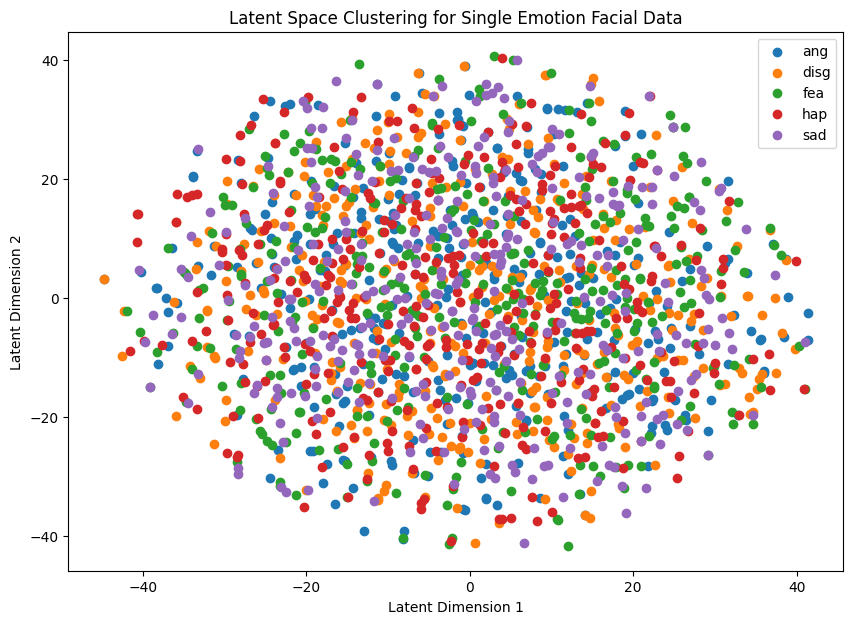

In [67]:

# Plot latent space
plt.style.use('default')
plt.figure(figsize=(10, 7))
for label in np.unique(single_labels):
    plt.scatter(single_latent_tsne[single_labels==label, 0], single_latent_tsne[single_labels==label, 1], label=single_label_mapping[label])
plt.legend()
plt.xlabel('Latent Dimension 1')
plt.ylabel('Latent Dimension 2')
plt.title('Latent Space Clustering for Single Emotion Facial Data')
plt.show()

## Mixed

In [84]:
# Label and data extraction
mix_string_label = mix_emo.iloc[:, 0].values
mix_data = mix_emo.iloc[:, 1:].values

# Label encoding
mix_labels = le.fit_transform(mix_string_label)
mix_label_mapping = dict(zip(mix_labels, mix_string_label))

In [71]:
# Train test split
mix_X_train, mix_X_val, mix_y_train, mix_y_val = train_test_split(mix_data, mix_labels, test_size=0.2, random_state=42)

In [72]:
# mix emotion dataset
mix_train_dataset = CustomDataset(torch.tensor(mix_X_train, dtype=torch.float32), torch.tensor(mix_y_train, dtype=torch.long))
mix_val_dataset = CustomDataset(torch.tensor(mix_X_val, dtype=torch.float32), torch.tensor(mix_y_val, dtype=torch.long))
mix_complete_dataset = CustomDataset(torch.tensor(mix_data, dtype=torch.float32), torch.tensor(mix_labels, dtype=torch.long))

In [73]:
# mix emotion dataloader
mix_train_loader = DataLoader(mix_train_dataset, batch_size=32, shuffle=True)
mix_val_loader = DataLoader(mix_val_dataset, batch_size=32, shuffle=False)
mix_complete_loader = DataLoader(mix_complete_dataset, batch_size=32, shuffle=False)

In [74]:
train_test_vae(epochs, mix_train_loader, mix_val_loader, mix_vae, mix_optimizer)

Epoch 1, Train Loss: 0.0313
Epoch 1, Val Loss: 0.0066
Epoch 2, Train Loss: 0.0041
Epoch 2, Val Loss: 0.0034
Epoch 3, Train Loss: 0.0031
Epoch 3, Val Loss: 0.0031
Epoch 4, Train Loss: 0.0030
Epoch 4, Val Loss: 0.0030
Epoch 5, Train Loss: 0.0029
Epoch 5, Val Loss: 0.0030
Epoch 6, Train Loss: 0.0028
Epoch 6, Val Loss: 0.0029
Epoch 7, Train Loss: 0.0028
Epoch 7, Val Loss: 0.0028
Epoch 8, Train Loss: 0.0027
Epoch 8, Val Loss: 0.0028
Epoch 9, Train Loss: 0.0027
Epoch 9, Val Loss: 0.0027
Epoch 10, Train Loss: 0.0027
Epoch 10, Val Loss: 0.0028
Epoch 11, Train Loss: 0.0026
Epoch 11, Val Loss: 0.0027
Epoch 12, Train Loss: 0.0026
Epoch 12, Val Loss: 0.0027
Epoch 13, Train Loss: 0.0026
Epoch 13, Val Loss: 0.0027
Epoch 14, Train Loss: 0.0026
Epoch 14, Val Loss: 0.0027
Epoch 15, Train Loss: 0.0026
Epoch 15, Val Loss: 0.0026
Epoch 16, Train Loss: 0.0026
Epoch 16, Val Loss: 0.0027
Epoch 17, Train Loss: 0.0026
Epoch 17, Val Loss: 0.0027
Epoch 18, Train Loss: 0.0026
Epoch 18, Val Loss: 0.0027
Epoch 19, 

In [75]:
# Extract latent space from the validation dataset
mix_latent_space, mix_labels = extract_latent_space(mix_vae, mix_complete_loader)

In [76]:
# Use t-SNE to reduce into a 2D space
mix_vae_tsne = TSNE(n_components=2, random_state=42)
mix_latent_tsne = mix_vae_tsne.fit_transform(mix_latent_space)

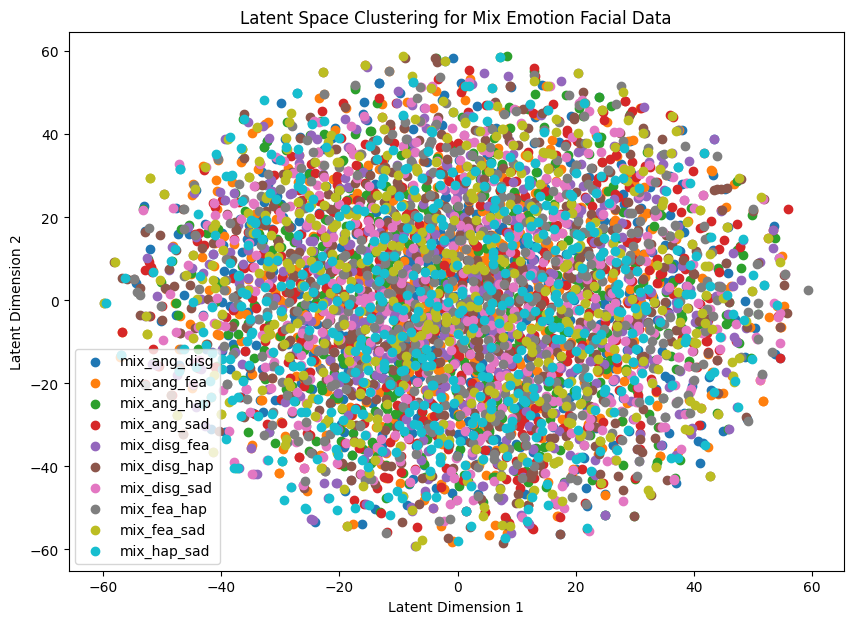

In [77]:
# Plot latent space
plt.style.use('default')
plt.figure(figsize=(10, 7))
for label in np.unique(mix_labels):
    plt.scatter(mix_latent_tsne[mix_labels==label, 0], mix_latent_tsne[mix_labels==label, 1], label=mix_label_mapping[label])
plt.legend()
plt.xlabel('Latent Dimension 1')
plt.ylabel('Latent Dimension 2')
plt.title('Latent Space Clustering for Mix Emotion Facial Data')
plt.show()

# t-SNE

## Single

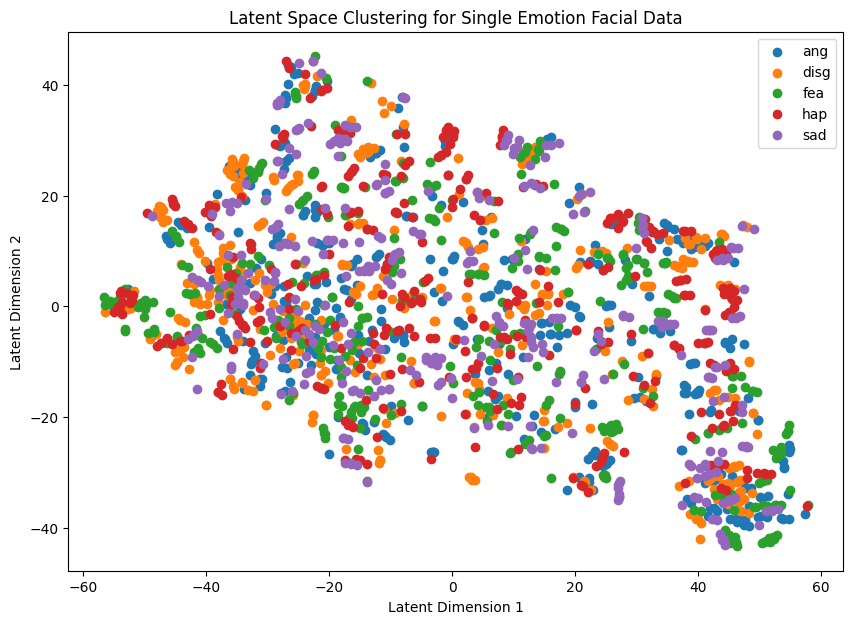

In [8]:
# 2D
single_tsne = TSNE(perplexity=50,n_components=2, random_state=42,n_iter=7100,learning_rate=40)
single_data_tsne = single_tsne.fit_transform(single_data)

# Plot latent space
plt.style.use('default')
plt.figure(figsize=(10, 7))
for label in np.unique(single_labels):
    plt.scatter(single_data_tsne[single_labels==label, 0], single_data_tsne[single_labels==label, 1], label=single_label_mapping[label])
plt.legend()
plt.xlabel('Latent Dimension 1')
plt.ylabel('Latent Dimension 2')
plt.title('Latent Space Clustering for Single Emotion Facial Data')
plt.show()

In [87]:
# 3D
single_3d_tsne = TSNE(perplexity=50,n_components=3, random_state=42,n_iter=7100,learning_rate=40)
single_data_3d_tsne = single_3d_tsne.fit_transform(single_data)


fig = px.scatter_3d(x=single_data_3d_tsne[:, 0], y=single_data_3d_tsne[:, 1], z=single_data_3d_tsne[:, 2],labels=single_label_mapping[], color=single_labels)

fig.show()

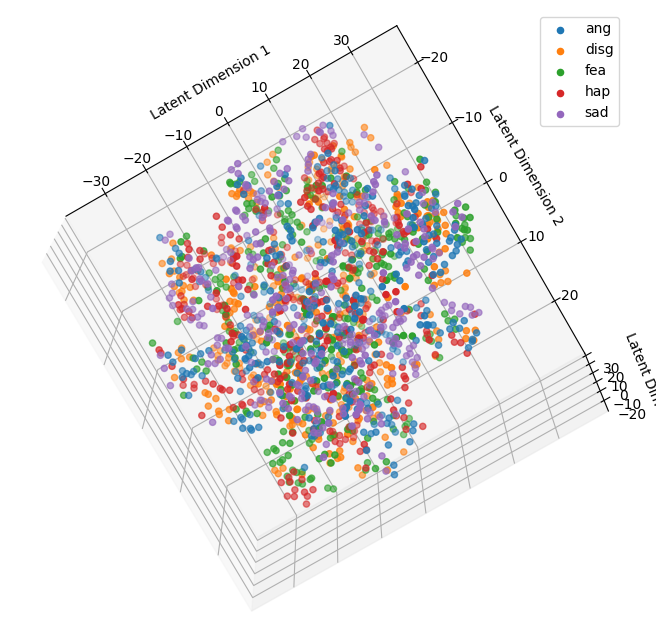

In [72]:
# Plot latent space
fig_3d = plt.figure(figsize=(8, 8))
ax = fig_3d.add_subplot(111, projection='3d')

for label in np.unique(single_labels):
    ax.scatter(single_data_3d_tsne[single_labels==label, 0], single_data_3d_tsne[single_labels==label, 1], single_data_3d_tsne[single_labels==label,2],label=single_label_mapping[label])

ax.legend()
ax.set_xlabel('Latent Dimension 1')
ax.set_ylabel('Latent Dimension 2')
ax.set_zlabel('Latent Dimension 3')

# View the plot from different angles
ax.view_init(elev=-80)
plt.show()

## Mix

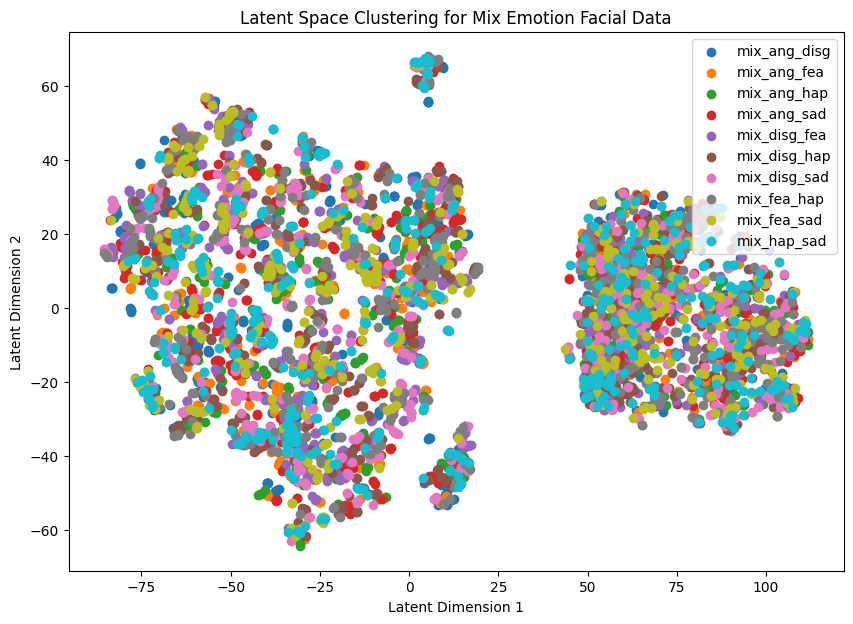

In [126]:
# 2D
mix_tsne = TSNE(perplexity=45,n_components=2, random_state=42,n_iter=6100,learning_rate=10)
mix_data_tsne = mix_tsne.fit_transform(mix_data)

# Plot latent space
plt.style.use('default')
plt.figure(figsize=(10, 7))
for label in np.unique(mix_labels):
    plt.scatter(mix_data_tsne[mix_labels==label, 0], mix_data_tsne[mix_labels==label, 1], label=mix_label_mapping[label])
plt.legend()
plt.xlabel('Latent Dimension 1')
plt.ylabel('Latent Dimension 2')
plt.title('Latent Space Clustering for Mix Emotion Facial Data')
plt.show()

In [85]:
# 3D
mix_3d_tsne = TSNE(perplexity=40,n_components=3, random_state=42,n_iter=5000,learning_rate=10)
mix_data_3d_tsne = mix_3d_tsne.fit_transform(mix_data)


fig_mix_3d = px.scatter_3d(x=mix_data_3d_tsne[:, 0], y=mix_data_3d_tsne[:, 1], z=mix_data_3d_tsne[:, 2],labels=mix_label_mapping, color=mix_labels)

fig_mix_3d.show()